# Import the Libraries needed

**pandas :** is a library written for the Python programming language allowing data manipulation and analysis. In particular, it provides data structures and operations for manipulating numerical arrays and time series.

**numpy :** is an extension of the Python programming language, designed to manipulate multidimensional matrices or arrays as well as mathematical functions operating on these arrays.

**matplotlib :** Matplotlib is a library of the Python programming language for plotting and visualizing data in graphical form. It can be combined with the NumPy and SciPy python libraries for scientific computation.

**Scipy :** is a project aiming to unify and federate a set of Python libraries for scientific use. Scipy uses the arrays and matrices of the NumPy module.

**Pickle :** is a python module that allows you to save one or more variables in a file and retrieve their values later. Variables can be of any type.

**librosa :** It is a Python module to analyze audio signals in general but geared more towards music. It includes the nuts and bolts to build a MIR(Music information retrieval) system.

**IPython.display :** lets you play audio directly in your notebook.

**Librosa :**  is a python package for music and audio analysis. It provides the building blocks necessary to create music information retrieval systems.


In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import sys
import os
import pickle
import librosa
import librosa.display
from IPython.display import Audio
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix
import tensorflow as tf
from tensorflow import keras
from keras.models import load_model
import seaborn as sns
import IPython.display as ipd

In [41]:
audio_data = r"C:\Users\siddh\OneDrive\Desktop\Genre\Datsaset\classical\classical.00096.wav"
data , sr = librosa.load(audio_data)
print(type(data), type(sr))

<class 'numpy.ndarray'> <class 'int'>


This step :

```
data , sr = librosa.load(audio_data)
```

loads and decodes the audio as a time series y, represented as a one-dimensional NumPy floating point array. The variable sr contains the sampling rate of y, that is, the number of samples per second of audio. By default, all audio is mixed to mono and resampled to 22050 Hz at load time. This behavior can be overridden by supplying additional arguments to librosa.load().

Audio will be automatically resampled to the given rate (default sr=22050).

To preserve the native sampling rate of the file, use sr=None.

We can change this behavior by resampling at 45.6KHz.

In [42]:
librosa.load(audio_data, sr=45600)

(array([-0.07759667, -0.10805783, -0.09840347, ..., -0.06370816,
        -0.05586784, -0.02773914], dtype=float32),
 45600)

This returns an audio time series as a numpy array with a default sampling rate(sr)

# Playing Audio:

With the use of IPython.display.Audio we will play the audio in our notebook.

In [43]:
import IPython
IPython.display.Audio(data, rate=sr)

# Visualizing Audio :

**Plot Raw Wave File** : 

Plot Raw Wave plot is the amplitude envelope of a waveform

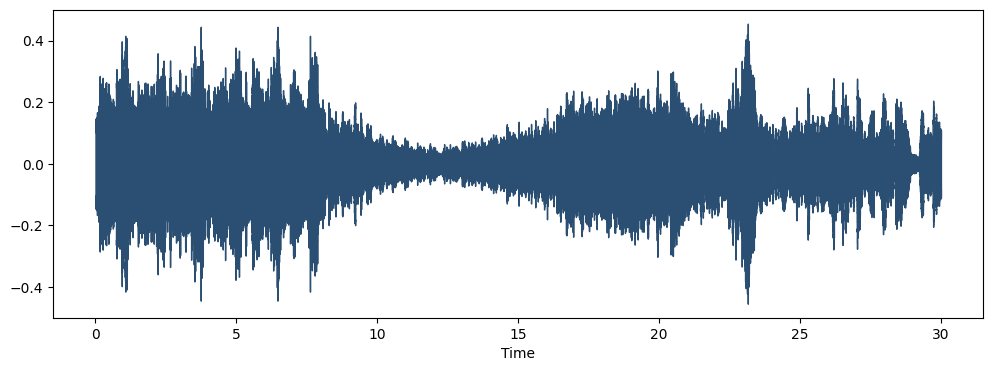

In [44]:
plt.figure(figsize=(12, 4))
librosa.display.waveshow(data, color = "#2B4F72")
plt.show()

**Plot Spectrogram**:

A spectrogram is a visual way of representing the signal loudness, of a signal over time at various frequencies present in a particular waveform. Not only can one see whether there is more or less energy at, for example, 2 Hz vs 10 Hz, but one can also see how energy levels vary over time.

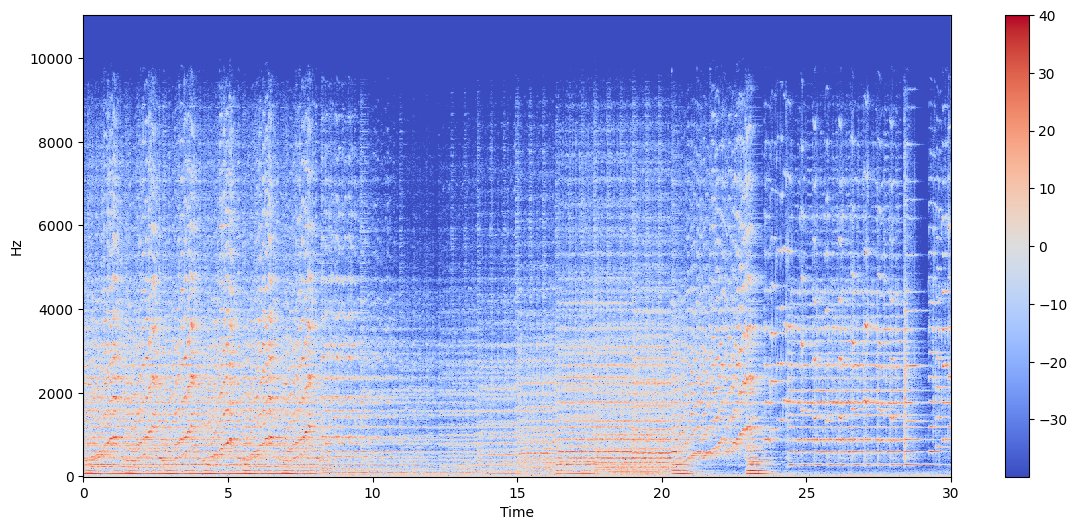

In [45]:
X = librosa.stft(data)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 6))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

The vertical axis represents frequencies (from 0 to 10kHz), and the horizontal axis represents the time of the clip. 


Let's Convert the frequency axis to a logarithm , because we see that all actions (in red) is taking place at the bottom of the spectrum.

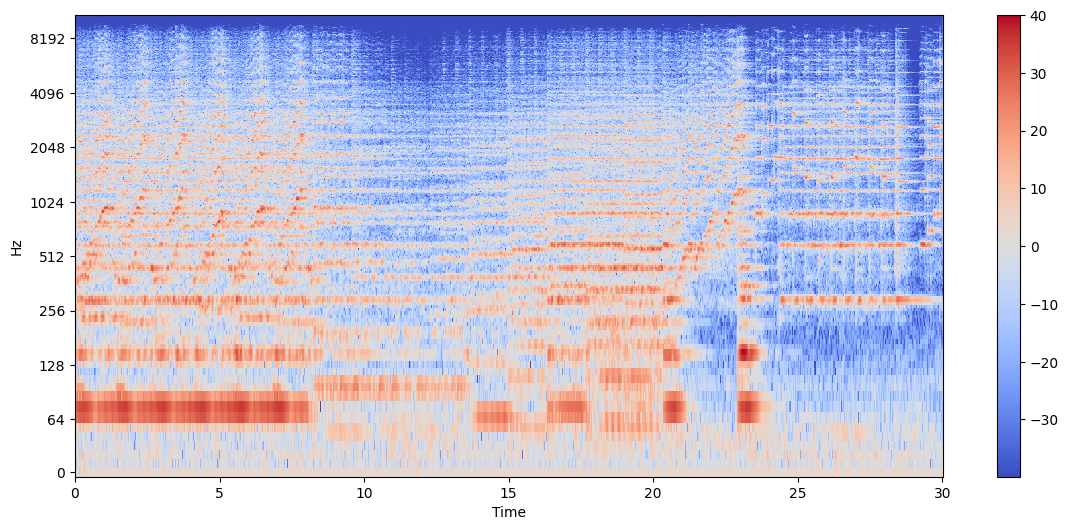

In [46]:
plt.figure(figsize=(14, 6))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
plt.colorbar()

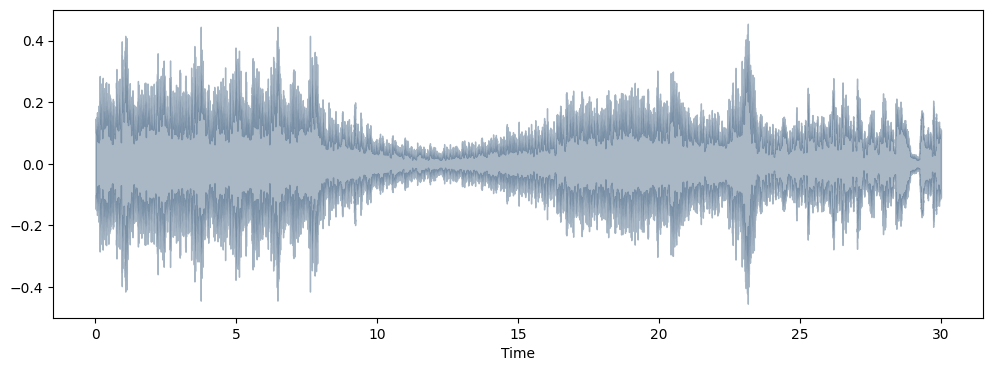

In [47]:
from sklearn.preprocessing import normalize
spectral_rolloff = librosa.feature.spectral_rolloff(y=data+0.01, sr=sr)[0]
plt.figure(figsize=(12, 4))
librosa.display.waveshow(data, sr=sr, alpha=0.4, color = "#2B4F72")

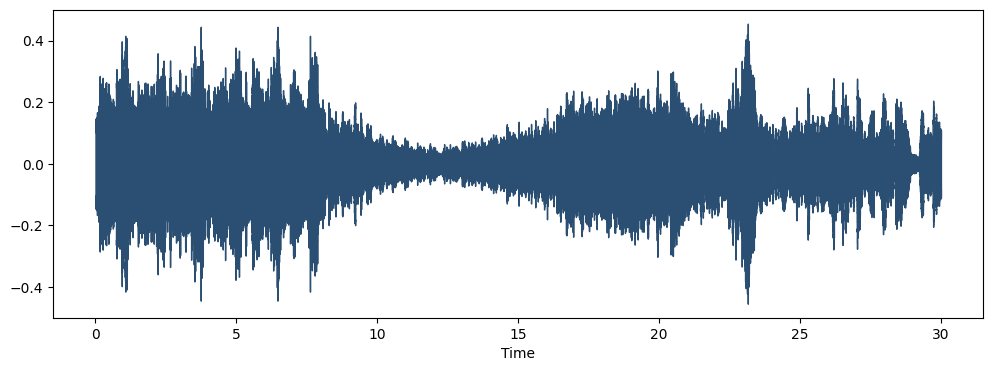

In [48]:
plt.figure(figsize=(12, 4))
librosa.display.waveshow(data, sr=sr, color="#2B4F72")

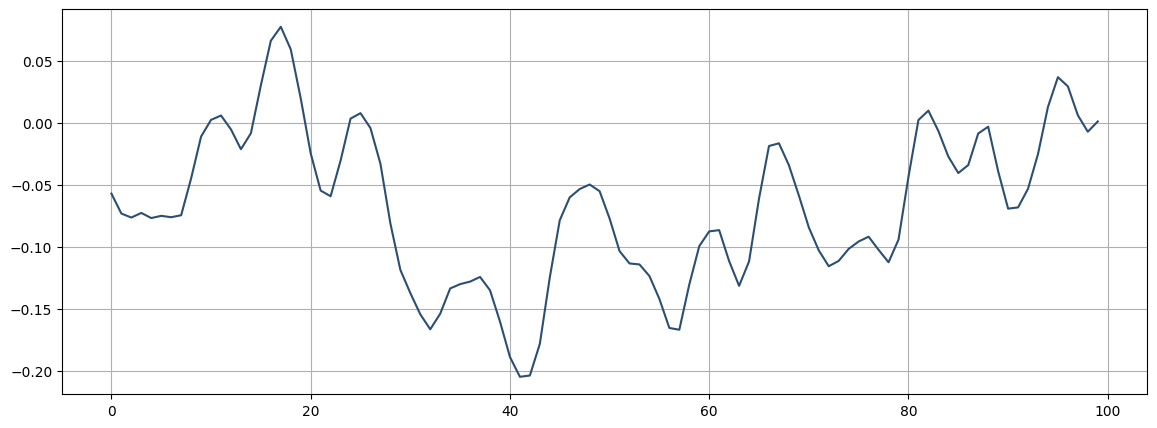

In [49]:
# Zooming in
n0 = 9000
n1 = 9100
plt.figure(figsize=(14, 5))
plt.plot(data[n0:n1], color="#2B4F72")
plt.grid()

The graph shows 11 zero crossings. Let’s verify it with Librosa.

In [50]:
zero_crossings = librosa.zero_crossings(data[n0:n1], pad=False)
print("The number of zero-crossings is :",sum(zero_crossings))

The number of zero-crossings is : 11


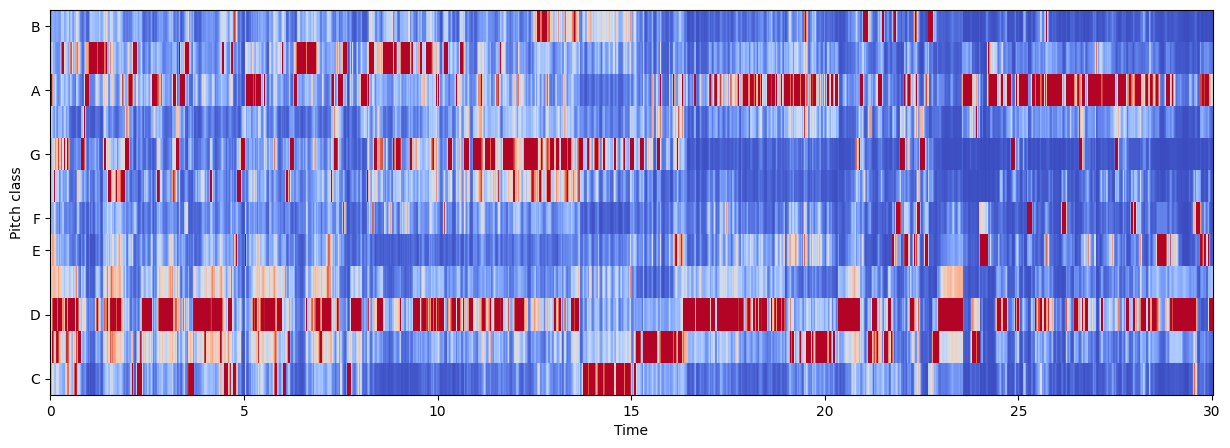

In [51]:
chromagram = librosa.feature.chroma_stft(y=data, sr=sr)
plt.figure(figsize=(15, 5))
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', cmap='coolwarm')

# Training Our Model

**Classification**

Our Datasets contains 10 genres :
*   Blues
*   Classical
*   Country
*   Disco
*   Hiphop
*   Jazz
*   Metal
*   Pop
*   Reggae
*   Rock

In [52]:
%matplotlib inline
from keras import layers
import keras

In [53]:
df1 = pd.read_csv(r"C:\Users\siddh\OneDrive\Desktop\Genre\Datsaset\features_3_sec.csv")
df1.head()

filename  length  chroma_stft_mean  ...  mfcc20_mean  mfcc20_var  label
0  blues.00000.0.wav   66149          0.335406  ...    -0.243027   43.771767  blues
1  blues.00000.1.wav   66149          0.343065  ...     5.784063   59.943081  blues
2  blues.00000.2.wav   66149          0.346815  ...     2.517375   33.105122  blues
3  blues.00000.3.wav   66149          0.363639  ...     3.630866   32.023678  blues
4  blues.00000.4.wav   66149          0.335579  ...     0.536961   29.146694  blues

[5 rows x 60 columns]

In [54]:
df1.shape

(9990, 60)

In [55]:
df1.dtypes

filename                    object
length                       int64
chroma_stft_mean           float64
chroma_stft_var            float64
rms_mean                   float64
rms_var                    float64
spectral_centroid_mean     float64
spectral_centroid_var      float64
spectral_bandwidth_mean    float64
spectral_bandwidth_var     float64
rolloff_mean               float64
rolloff_var                float64
zero_crossing_rate_mean    float64
zero_crossing_rate_var     float64
harmony_mean               float64
harmony_var                float64
perceptr_mean              float64
perceptr_var               float64
tempo                      float64
mfcc1_mean                 float64
mfcc1_var                  float64
mfcc2_mean                 float64
mfcc2_var                  float64
mfcc3_mean                 float64
mfcc3_var                  float64
mfcc4_mean                 float64
mfcc4_var                  float64
mfcc5_mean                 float64
mfcc5_var           

We will drop the first column of "filename":

In [56]:
df1 = df1.drop(labels='filename',axis=1)

**Preprocessing the Data**

We will now focus on the last column "label" the categorical column and we will try to encode it with the function LabelEncoder() of sklearn.preprocessing.

In [57]:
genre_list = df1.iloc[:, -1]
encoder = LabelEncoder()

In [58]:
y = encoder.fit_transform(genre_list)

In [59]:
print(y)

[0 0 0 ... 9 9 9]


In [60]:
print(df1.iloc[:, :-1])

      length  chroma_stft_mean  ...  mfcc20_mean  mfcc20_var
0      66149          0.335406  ...    -0.243027   43.771767
1      66149          0.343065  ...     5.784063   59.943081
2      66149          0.346815  ...     2.517375   33.105122
3      66149          0.363639  ...     3.630866   32.023678
4      66149          0.335579  ...     0.536961   29.146694
...      ...               ...  ...          ...         ...
9985   66149          0.349126  ...     1.818823   38.966969
9986   66149          0.372564  ...     0.428857   18.697033
9987   66149          0.347481  ...    -0.299545   41.586990
9988   66149          0.387527  ...     0.675824   12.787750
9989   66149          0.369293  ...    -3.412534   31.727489

[9990 rows x 58 columns]


In [61]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(np.array(df1.iloc[:, :-1], dtype = float))

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [63]:
from keras.models import Sequential

In [67]:
# Neural network
model = Sequential()
model.add(layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

C:\Users\siddh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [68]:
classifier = model.fit(X_train,
                    y_train,
                    epochs=100,
                    batch_size=128)

Epoch 1/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3716 - loss: 1.8028
Epoch 2/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6749 - loss: 0.9510
Epoch 3/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7618 - loss: 0.7201
Epoch 4/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step - accuracy: 0.8013 - loss: 0.5717
Epoch 5/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8378 - loss: 0.4847
Epoch 6/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8681 - loss: 0.4011
Epoch 7/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step - accuracy: 0.8937 - loss: 0.3445
Epoch 8/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step - accuracy: 0.9084 - loss: 0.3033
Epoch 9/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9276 - loss: 0.2492
Epoch 10/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9432 - loss: 0.2072
Epoch 11/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9489 - loss: 0.1828
Epoch 12/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step - a

In [69]:
test_loss, test_acc  = model.evaluate(X_test, y_test, batch_size=128)

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 623us/step - accuracy: 0.8835 - loss: 0.5595


In [70]:
print(f"The test loss is: {test_loss * 100:.2f}%\nThe test accuracy is: {test_acc * 100:.2f}%")


The test loss is: 61.02%
The test accuracy is: 88.11%


In [71]:
import tensorflow as tf

# Save the trained model
model.save('music_genre_classifier.keras')


104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
Precision (Weighted): 0.96
Recall (Weighted): 0.96
F1 Score (Weighted): 0.96

Classification Report:
              precision    recall  f1-score   support

       blues       0.99      0.97      0.98       345
   classical       0.96      0.99      0.98       334
     country       0.93      0.95      0.94       313
       disco       0.94      0.94      0.94       335
      hiphop       0.97      0.96      0.96       340
        jazz       0.96      0.95      0.96       313
       metal       0.97      0.99      0.98       340
         pop       0.93      0.97      0.95       300
      reggae       0.96      0.96      0.96       341
        rock       0.96      0.91      0.93       336

    accuracy                           0.96      3297
   macro avg       0.96      0.96      0.96      3297
weighted avg       0.96      0.96      0.96      3297



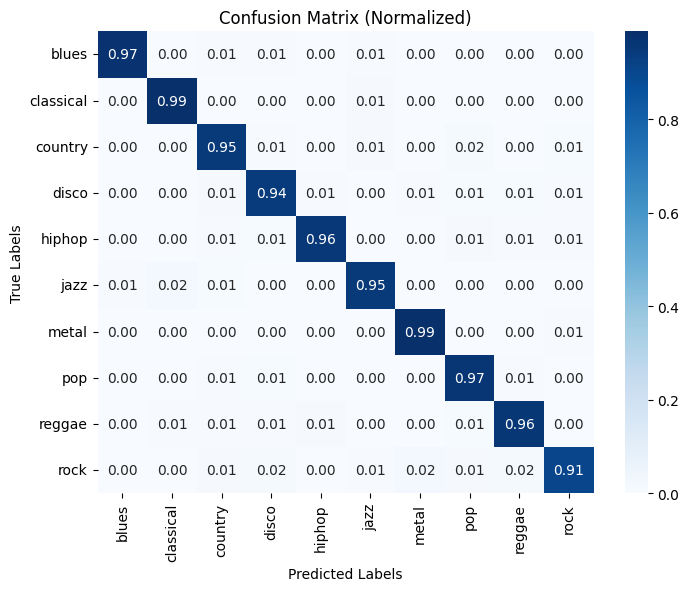

In [ ]:


# Load dataset
df1 = pd.read_csv(r"C:\Users\siddh\OneDrive\Desktop\Genre\Datsaset\features_3_sec.csv")

# Drop unnecessary columns and preprocess labels
df1 = df1.drop(labels='filename', axis=1)
genre_list = df1.iloc[:, -1]
encoder = LabelEncoder()
y = encoder.fit_transform(genre_list)
genre_labels = encoder.classes_

# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(np.array(df1.iloc[:, :-1], dtype=float))

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Load the trained model
model = load_model('music_genre_classifier.keras')

# Predict on the test set
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# Calculate metrics
precision = precision_score(y_test, y_pred_labels, average='weighted')
recall = recall_score(y_test, y_pred_labels, average='weighted')
f1 = f1_score(y_test, y_pred_labels, average='weighted')

# Print metrics
print(f"Precision (Weighted): {precision:.2f}")
print(f"Recall (Weighted): {recall:.2f}")
print(f"F1 Score (Weighted): {f1:.2f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_labels, target_names=genre_labels))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_labels, normalize='true')

# Confusion Matrix Visualization
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=genre_labels, yticklabels=genre_labels)
plt.title('Confusion Matrix (Normalized)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
